# Playing with QuTiP

In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

## A spin chain of three atoms
(As per this paper from Antoine Browaey's experiment: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.113002.)
Three atoms coupled to two Rydberg states that have a resonant dipole-dipole interaction with each other. We start with the state $|\!\uparrow\downarrow\downarrow\rangle$ and look at how the excitation $\uparrow$ moves back and forth. For now we don't think about dephasing.

For $N$ atoms, the Hamiltonian we're dealing with is
$$ H = \frac{1}{2} \sum\limits_{i\neq j} \frac{C_3}{R_{ij}^3} \left( \sigma_i^+\sigma_j^- + \sigma_i^-\sigma_j^+ \right),$$
where $\sigma^{\pm} = \sigma^x \pm i\sigma^y$ such that this effectively describes a flip-flop interaction.

We define the Rydberg parameters:

In [2]:
C3 = 7965    # MHz/um^3
R = 20       # um
N = 3

Now we define different operators. The individual spin-matrices work on a single atom, so we need to form tensor products to get a one-atom operator defined in the basis of the entire system. To this end we use the `tensor()` function in QuTiP.

In [3]:
sigmaplus = []
sigmaminus = []
pops = []
szs = []
si = qeye(2)

pairoperators = []

for i in range(N):
    oplist = []
    for j in range(N):
        oplist.append(si)
    
    oplist[i] = sigmax() + 1j*sigmay()
    sigmaplus.append(tensor(oplist))
    
    oplist[i] = sigmax() - 1j*sigmay()
    sigmaminus.append(tensor(oplist))
    
    oplist[i] = (1-sigmaz())/2
    pops.append(tensor(oplist))
    
    oplist[i] = sigmaz()
    szs.append(tensor(oplist))

Having defined the operators, we can combine them to set up the Hamiltonian.

In [4]:
H = 0
for i in range(N):
    for j in range(i + 1, N):
        H += C3/(R*(j - i))**3 * ( sigmaplus[i] * sigmaminus[j] + sigmaminus[i] * sigmaplus[j] )

All that's left is defining intial conditions, and the times we want to state of our system. We define those here, and then we run a simple Schrödinger solver.

In [5]:
psi_list = []
for n in range(N):
    psi_list.append(basis(2, 0))

psi_list[0] = basis(2, 1)
psi0 = tensor(psi_list)

tlist = np.linspace(0, 5, 10000)
result = sesolve(H, psi0, tlist, e_ops = pops)

Plot the result.

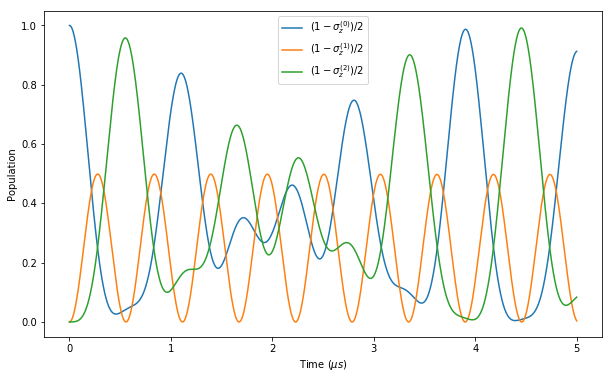

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(N):
    ax.plot(tlist, result.expect[i], label=r'$(1-\sigma_z^{(%d)})/2$'%i)
    
ax.set_xlabel('Time ($\mu s$)')
ax.set_ylabel('Population')
ax.legend()
plt.show()

## Dephasing Rabi oscillation

Next, we'll simulate a driven two-level system in the presence of some dephasing. In the interaction picture the Hamiltonian is
$$H = -\Delta |e\rangle\langle e| + \frac{\Omega}{2}\left( |e\rangle\langle g| + |g\rangle\langle e| \right) = -\frac{\Delta}{2} \left(1 - \sigma^z\right) + \frac{\Omega\sigma^x}{2}$$

In [3]:
delta = 0
omega = 0.1*2*np.pi
H = -delta/2 * (1 - sigmaz()) + omega * sigmax()/2

Dephasing with rate $\Gamma$ is described by the jump operator
$$L = \sqrt{\Gamma} |g\rangle\langle e|$$

In [25]:
gamma = 0.40*omega #1/15.6
L = np.sqrt(gamma)*Qobj([[0,1], [0,0]])

In [26]:
psi0 = basis(2, 0)
timeax = np.linspace(0, 100, 500)
result = mesolve(H, psi0, timeax, e_ops = (1 - sigmaz())/2, c_ops = L)

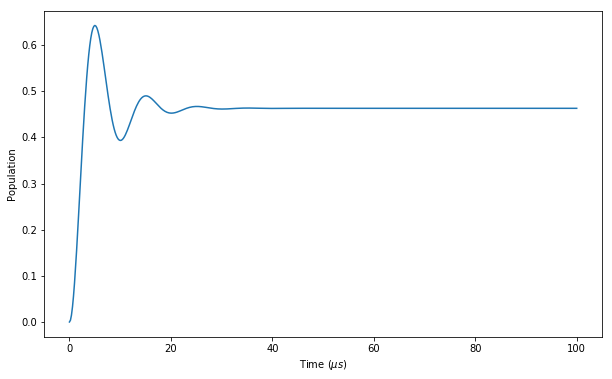

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(timeax, result.expect[0])
    
ax.set_xlabel('Time ($\mu s$)')
ax.set_ylabel('Population')
plt.show()

Alternatively we could use Quantum Monte Carlo to get the same result. In this case it's much slower, but it scales more favorably with system size. See, for instance, this paper by Dalibard, Castin, and Molmer: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.68.580.

In [34]:
psi0 = basis(2, 0)
timeax = np.linspace(0, 20, 5000)
result = mcsolve(H, psi0, timeax, e_ops = [(1 - sigmaz())/2, (1 + sigmaz())/2], c_ops = L, ntraj = 1)

100.0%. Run time:   2.96s. Est. time left: 00:00:00:00
Total run time:   3.13s


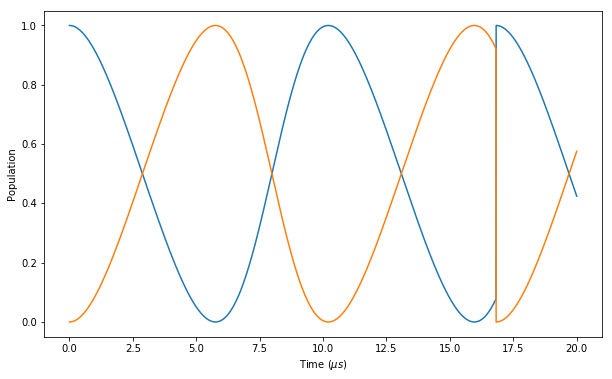

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(timeax, result.expect[1])
ax.plot(timeax, result.expect[0])
    
ax.set_xlabel('Time ($\mu s$)')
ax.set_ylabel('Population')
plt.show()

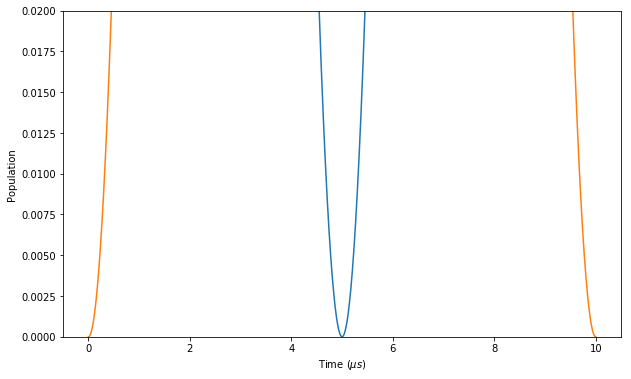

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(timeax, result.expect[1])
ax.plot(timeax, result.expect[0])
    
ax.set_xlabel('Time ($\mu s$)')
ax.set_ylabel('Population')
plt.ylim((0, 0.02))
plt.show()